# face_morphing.ipynb
This Jupyter Notebook was written while following the book "Image Processing Masterclass with Python" by Sandipan Dey.

## Face morphing with dlib, scipy.spatial, and opencv-python

In [1]:
from scipy.spatial import Delaunay
from skimage.io import imread
import scipy.misc
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt



In [2]:
# compute the 68 face landmarks from the human face 
def extract_landmarks(img, add_boundary_points=True, predictor_path = 'models/shape_predictor_68_face_landmarks.dat'):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    try:
        dets = detector(img, 1)
        points = np.zeros((68, 2))
        for k, d in enumerate(dets):
            print(f"Detection {k}: Left: {d.left()} Top: {d.top()} Right: {d.right()} Bottom: {d.bottom()}")
            
        # Get the landmarks for the face in box d.
        shape = predictor(img, d)
        for i in range(68):
            points[i, 0] = shape.part(i).x
            points[i, 1] = shape.part(i).y
    except Exception as e:
        print('Failed finding face points: ', e)
        return []
    points = points.astype(np.int32)
    return points

In [4]:
# extract the landmarks for both the source and destination face images
src_path = 'images/img_01.JPG'
dst_path = 'images/img_02.JPG'
src_img = imread(src_path)
dst_img = imread(dst_path)
src_points = extract_landmarks(src_img)
dst_points = extract_landmarks(dst_img)

Detection 0: Left: 63 Top: 99 Right: 384 Bottom: 420
Detection 0: Left: 280 Top: 428 Right: 946 Bottom: 1094


In [5]:
# compute alpha-blending of two sets of points and two images
def weighted_average_points(start_points, end_points, percent=0.5):
        if percent <= 0:
            return end_points
        elif percent >= 1:
            return start_points
        else:
            return np.asarray(start_points*percent + end_points*(1-percent), np.int32)

In [6]:
# interpolate over every image channel
def bilinear_interpolate(img, coords):
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0+1]
    q12 = img[y0+1, x0]
    q22 = img[y0+1, x0+1]
    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

In [7]:
# generate an array of all possible (x, y) grid coordinates within the region of interest (ROI) of input points 
def get_grid_coordinates(points):
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1
    return np.asarray([(x, y) for y in range(ymin, ymax) for x in range(xmin, xmax)], np.uint32)

In [8]:
# warp each triangle from the src_img only within the ROI of the result_img
def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    roi_coords = get_grid_coordinates(dst_points)

    # indices to vertices. -1 if pixel is not in any triangle
    roi_tri_indices = delaunay.find_simplex(roi_coords)
    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index], np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)
    return None 


In [9]:
# calculate the affine transformation matrix for each triangle vertex (x, y) from dest_points to src_points
def get_triangular_affine_matrices(vertices, src_points, dest_points):
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat   

In [ ]:
# compute the morphed output image and the corresponding Delaunay triangulation of the face landmarks
def warp_image(src_img, src_points, dest_points, dest_shape, dtype=np.uint8):
    num_chans = 3
    src_img = src_img[:, :, :3]
    rows, cols = dest_shape[:2]
    result_img = np.zeros((rows, cols, num_chans), dtype)
    delaunay = Delaunay(dest_points)
    tri_affines = np.asarray(list(get_triangular_affine_matrices(delaunay.simplices, src_points, dest_points)))
    process_warp(src_img, result_img, tri_affines, dest_points, delaunay)
    return result_img, delaunay

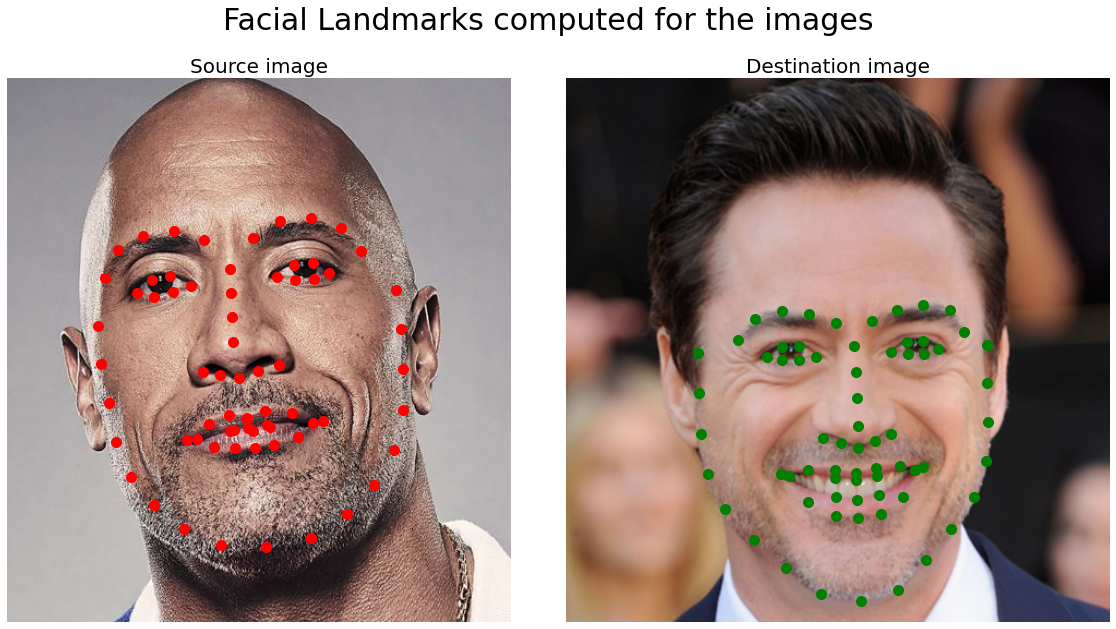

In [10]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(src_img)
for i in range(68):
    plt.plot(src_points[i,0], src_points[i,1], 'r.', markersize=20)
plt.title('Source image', size=20)
plt.axis('off')
plt.subplot(122)
plt.imshow(dst_img)
for i in range(68):
    plt.plot(dst_points[i,0], dst_points[i,1], 'g.', markersize=20)
plt.title('Destination image', size=20)
plt.axis('off')
plt.suptitle('Facial Landmarks computed for the images', size=30)
fig.subplots_adjust(wspace=0.01, left=0.1, right=0.9)

plt.show()